# Seno na NN

In [148]:
import os
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib
# matplotlib.style.use('dark_background')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold, StratifiedKFold

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset


# Configuração do dispositivo para GPU, se disponível
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
try:
    print(torch.cuda.get_device_name(device))
except Exception as e:
    print('CUDA device not found, using CPU instead.')

# Semente para reprodutibilidade
_seed = 78645

NVIDIA GeForce GTX 1060 6GB


In [149]:
def create_sine_wave_dataset(num_points, num_degrees, variation=0.1):
    """
    Cria um conjunto de dados de onda senoidal com ruído aleatório.

    Parâmetros:
    - num_points (int): Número de pontos de dados a serem gerados.
    - num_degrees (int): Número de graus para a onda senoidal.
    - variation (float): Amplitude da variação aleatória a ser adicionada.

    Retorna:
    - pd.DataFrame: DataFrame contendo o conjunto de dados de onda senoidal.
    """
    # Criar um array com os graus em radianos (0 a 360)
    degrees = np.linspace(0, 360, num_degrees, endpoint=True)
    radians = np.radians(degrees)
    
    # Criar uma lista vazia para armazenar os dados
    data = []
    
    # Gerar os pontos ao longo da onda senoidal e armazená-los na lista data
    for i in range(num_points):
        if variation == 0:
            sine_wave = np.sin(radians)
        else:
            sine_wave = np.sin(radians) + np.random.uniform(-variation, variation, num_degrees)
        data.append(sine_wave)
    
    # Criar o DataFrame usando a lista data e os graus como nome das colunas
    df = pd.DataFrame(data, columns=[f'{degree:.0f}' for degree in degrees])
    return df

In [210]:
# Exemplo de uso: criar uma base de dados com 100 pontos e 125 graus, com variação de 0.1
dataset_orig = create_sine_wave_dataset(num_points=1, num_degrees=360, variation=0).T
dataset_orig = dataset_orig.reset_index()
dataset_orig.columns = ['x', 'sin(x)']

# Convertendo para numpy arrays
dataset_orig_x = dataset_orig['x'].to_numpy(dtype=np.float64)
dataset_orig_y = dataset_orig['sin(x)'].to_numpy(dtype=np.float64)

# Dividindo o conjunto de dados em treino e validação
X_train, X_valid, y_train, y_valid = train_test_split(dataset_orig_x.reshape(-1, 1), dataset_orig_y, train_size=0.9, test_size=0.1, random_state=_seed)


Iteration 1, loss = 7.05570624
Iteration 2, loss = 6.82609512
Iteration 3, loss = 6.60233564
Iteration 4, loss = 6.38366683
Iteration 5, loss = 6.16970961
Iteration 6, loss = 5.96268682
Iteration 7, loss = 5.75994240
Iteration 8, loss = 5.56424741
Iteration 9, loss = 5.37169604
Iteration 10, loss = 5.18644649
Iteration 11, loss = 5.00510296
Iteration 12, loss = 4.82833346
Iteration 13, loss = 4.65726123
Iteration 14, loss = 4.48912456
Iteration 15, loss = 4.32504213
Iteration 16, loss = 4.16572807
Iteration 17, loss = 4.00766220
Iteration 18, loss = 3.84635491
Iteration 19, loss = 3.37021480
Iteration 20, loss = 0.74709021
Iteration 21, loss = 0.70650420
Iteration 22, loss = 0.68584234
Iteration 23, loss = 0.66631517
Iteration 24, loss = 0.64740576
Iteration 25, loss = 0.62904832
Iteration 26, loss = 0.61116829
Iteration 27, loss = 0.59377738
Iteration 28, loss = 0.57701855
Iteration 29, loss = 0.56064652
Iteration 30, loss = 0.54480334
Iteration 31, loss = 0.52948399
Iteration 32, los

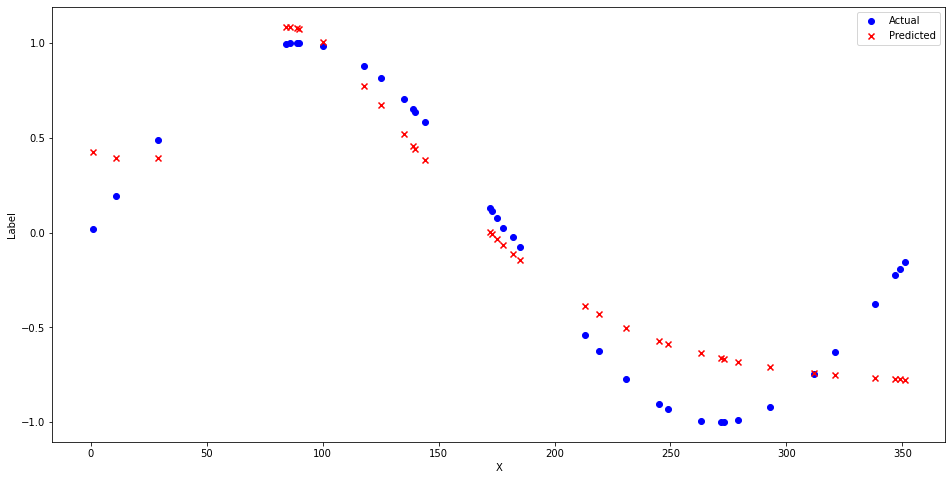

In [228]:
# Definindo e treinando o regressor MLP com parâmetros ajustados
regressor = MLPRegressor(solver='adam', activation='tanh', alpha=1e-4, learning_rate_init = 0.001, hidden_layer_sizes=(2,), batch_size=16,  max_iter=10000, random_state=_seed, tol = 1e-6, verbose=True)
regressor.fit(X_train, y_train)

# Prevendo os valores de validação
y_pred = regressor.predict(X_valid)

# Plotando os resultados
plt.figure(figsize=(16, 8))
plt.scatter(X_valid, y_valid, color='blue', label='Actual')
plt.scatter(X_valid, y_pred, color='red', label='Predicted', marker='x')
plt.xlabel('X')
plt.ylabel('Label')
plt.legend()
plt.show()

# Reconstrução Seno com Autoencoder Variacional (VAE)

<!-- Codigo realizado e implementado por Matheus Becali Rocha -->
<!-- E-mail: matheusbecali@gmail.com -->
<!--  
  .---------.
  |.-------.|
  ||>.py#  ||
  ||       ||
  |"-------'|
.-^---------^-.
| ---~   BKLY |
"-------------'
-->

In [24]:
import os
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib
# matplotlib.style.use('dark_background')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset


# Configuração do dispositivo para GPU, se disponível
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
try:
    print(torch.cuda.get_device_name(device))
except Exception as e:
    print('CUDA device not found, using CPU instead.')

# Semente para reprodutibilidade
_seed = 78645

NVIDIA GeForce GTX 1060 6GB


## Funções Auxiliares

Este script define Funções auxiliares que serão utilizadas ao longo do código.

Ele inclui:
- Definição de uma função para criação de um conjunto de dados de onda senoidal com ruído aleatório;
- Definição de uma função para converter dados em tensores e prepara DataLoader para PyTorch;
- Definição de uma função para a plotagem dos gráficos de espectro de dados de entrada e reconstruídos.

In [33]:
def create_sine_wave_dataset(num_points, num_degrees, variation=0.1):
    """
    Cria um conjunto de dados de onda senoidal com ruído aleatório.

    Parâmetros:
    - num_points (int): Número de pontos de dados a serem gerados.
    - num_degrees (int): Número de graus para a onda senoidal.
    - variation (float): Amplitude da variação aleatória a ser adicionada.

    Retorna:
    - pd.DataFrame: DataFrame contendo o conjunto de dados de onda senoidal.
    """
    # Criar um array com os graus em radianos (0 a 360)
    degrees = np.linspace(0, 360, num_degrees, endpoint=True)
    radians = np.radians(degrees)
    
    # Criar uma lista vazia para armazenar os dados
    data = []
    
    # Gerar os pontos ao longo da onda senoidal e armazená-los na lista data
    for i in range(num_points):
        if variation == 0:
            sine_wave = np.sin(radians)
        else:
            sine_wave = np.sin(radians) + np.random.uniform(-variation, variation, num_degrees)
        data.append(sine_wave)
    
    # Criar o DataFrame usando a lista data e os graus como nome das colunas
    df = pd.DataFrame(data, columns=[f'{degree:.0f}°' for degree in degrees])
    return df

# Convert to Tensors and prepare data loaders
def prepare_data_loader(data, target, batch_size=1, shuffle=True):
    """
    Converte dados em tensores e prepara DataLoader para PyTorch.

    Parâmetros:
    - data (pd.DataFrame ou np.ndarray): Dados de entrada.
    - target (pd.DataFrame ou np.ndarray): Dados de saída ou alvo.
    - batch_size (int): Tamanho do lote (batch).
    - shuffle (bool): Se deve embaralhar os dados.

    Retorna:
    - torch.utils.data.DataLoader: DataLoader configurado.
    - dict: Dicionário com tamanhos dos tensores de entrada e saída.
    """
    tensor_data = torch.tensor(np.array(data, dtype=np.float32))
    tensor_target = torch.tensor(np.array(target, dtype=np.float32))
    dataset = torch.utils.data.TensorDataset(tensor_data, tensor_target)
    dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)
    size = {'x_size': tensor_data.size(),
            'y_size': tensor_target.size()}
    return dataloader, size

def plot_gallery(dataset, spectre, epoch, fold, n_row=3, n_col=6, all_plot=False):
    """
    Plota uma galeria de gráficos de espectro de dados de entrada e reconstruídos.

    Parâmetros:
    - dataset (pd.DataFrame): Conjunto de dados com os nomes das colunas.
    - spectre (torch.Tensor): Tensores contendo os dados de espectro.
    - epoch (int): Número da época atual.
    - fold (int): Número do fold atual.
    - n_row (int): Número de linhas no gráfico.
    - n_col (int): Número de colunas no gráfico.
    - all_plot (bool): Se deve plotar todos os espectros ou apenas um subset.

    Retorna:
    - None
    """
    eixo_x = dataset.columns.values
    # print(eixo_x.values)
    if all_plot:
        plt.figure(figsize=(8 * n_col, 8 * n_row))
        for i in range(spectre[0].size()[0]):
            for j in range(n_row * n_col):
                ax = plt.subplot(n_row, n_col, j + 1)
                if j == 0: 
                    ax.set_title("Input Data")
                else:
                    ax.set_title("Recon Data")
                ax.axis("off")
                ax.plot(eixo_x, spectre[j][i].squeeze(0))
        plt.savefig(f'imgs/image_at_epoch_{epoch:04d}_fold_{str(fold)}.png')
        plt.show()
        plt.close()
    else:
        plt.figure(figsize=(2 * n_col, 2 * n_row))
        for i in range(n_row * n_col):
            ax = plt.subplot(n_row, n_col, i + 1)
            if i == 0: 
                ax.set_title("Input Data")
            else:
                ax.set_title("Recon Data")
            ax.axis("off")
            ax.plot(eixo_x, spectre[i][0].squeeze(0))

        plt.savefig(f'imgs/image_at_epoch_{epoch:04d}_fold_{str(fold)}.png')
        plt.show()
        plt.close()

## VAE

Este script define um Autoencoder Variacional (VAE) com camadas convolucionais e blocos ResNet1D. 

Ele inclui:
- Definição do bloco ResNet1D;
- Definição do VAE e suas respectivas funções:
    - Encoder;
    - Decoder;
    - Truque para reparametrização;
    - Amostragem do vetor latente;
    - Média e Desvio padrão;
    - Forward.

In [26]:
model_name = 'E_MLP-IR_Linear'
conv = False

# Define the ResNet1D block
class ResNet1DBlock(nn.Module):
    """
    Define um bloco ResNet1D para uso em redes neurais convolucionais 1D.

    Parâmetros:
    - in_channels (int): Número de canais de entrada.
    - out_channels (int): Número de canais de saída.
    - kernel_size (int): Tamanho do kernel da convolução.
    - stride (int): Passo da convolução.
    - padding (int): Preenchimento da convolução.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ResNet1DBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.tanh = nn.Tanh()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding)
        self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride)

    def forward(self, x):
        """
        Define a passagem para frente do bloco ResNet1D.

        Parâmetros:
        - x (torch.Tensor): Tensor de entrada.

        Retorna:
        - torch.Tensor: Tensor após passar pelo bloco ResNet1D.
        """
        out = self.conv1(x)
        out = self.tanh(out)
        out = self.conv2(out)
        shortcut = self.shortcut(x)
        out += shortcut
        out = self.tanh(out)
        return out    
    
class VAE(nn.Module):
    """
    Define uma Variational Autoencoder (VAE) com camadas convolucionais e ResNet1D blocks.

    Parâmetros:
    - layer_sizes (list): Tamanhos das camadas.
    - latent_dims (int): Dimensão do espaço latente.
    """
    def __init__(self, layer_sizes, latent_dims):
        super().__init__()

        self.encoder = nn.Sequential(OrderedDict([
            ('ConvUnit_1', nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1)),
            ('ConvUnit_2', ResNet1DBlock(32, 64)),
            ('ConvUnit_3', ResNet1DBlock(64, 128)),
        ]))

        with torch.no_grad():
            # Obter o tamanho da dimensão de saída da camada Flatten
            dummy_input = torch.randn(1, 1, 125)
            dummy_input = self.encoder(dummy_input)
            self.flattened_size = dummy_input.view(dummy_input.size(0), -1).size(1)

        self.mean_layer = nn.Linear(self.flattened_size,latent_dims) 
        self.logvar_layer = nn.Linear(self.flattened_size, latent_dims)      
        self.fc = nn.Linear(latent_dims, self.flattened_size)

        self.decoder = nn.Sequential(OrderedDict([
            ('DeLinearUnit_1', ResNet1DBlock(128, 64)),
            ('DeLinearUnit_2', ResNet1DBlock(64, 32)),
            ('DeLinearUnit_3', nn.Conv1d(32, 1, kernel_size=3, stride=1, padding=1)),
        ]))

    def encode(self, x):
        """
        Codifica a entrada para o espaço latente.

        Parâmetros:
        - x (torch.Tensor): Tensor de entrada.

        Retorna:
        - torch.Tensor: Mean (média) do espaço latente.
        - torch.Tensor: Log-variance (log variância) do espaço latente.
        """
        z = self.encoder(x)
        z = torch.reshape(z, (-1, self.flattened_size))
        mean = self.mean_layer(z)
        logvar = self.logvar_layer(z)

        return mean, logvar
    
    def decode(self, x):
        """
        Amostra um vetor latente a partir da entrada.

        Parâmetros:
        - x (torch.Tensor): Tensor de entrada.

        Retorna:
        - torch.Tensor: Vetor latente amostrado.
        """
        z = self.fc(x)
        z = torch.reshape(z, (-1, 128, self.flattened_size//128))
        z = self.decoder(z) 

        return z

    def reparameterize_trick(self, mean, logvar):
        """
        Aplica o truque de reparametrização para amostrar vetores latentes.

        Parâmetros:
        - mean (torch.Tensor): Média do espaço latente.
        - logvar (torch.Tensor): Log-variância do espaço latente.

        Retorna:
        - torch.Tensor: Vetor latente amostrado.
        """
        std_dev = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std_dev)

        return epsilon * std_dev + mean
    
    def sample_latent_vector(self, x):
        """
        Amostra um vetor latente a partir da entrada.

        Parâmetros:
        - x (torch.Tensor): Tensor de entrada.

        Retorna:
        - torch.Tensor: Vetor latente amostrado.
        """
        mean, logvar = self.encode(x)
        z = self.reparameterize_trick(mean, logvar)

        return z
    
    def mean_std(self, x):
        """
        Calcula a média e o desvio padrão do espaço latente.

        Parâmetros:
        - x (torch.Tensor): Tensor de entrada.

        Retorna:
        - torch.Tensor: Média do espaço latente.
        - torch.Tensor: Desvio padrão do espaço latente.
        """
        mean, logvar = self.encode(x)
        std_dev = torch.exp(0.5 * logvar)
        return mean, std_dev

    def forward(self, x):
        """
        Define a passagem para frente do VAE.

        Parâmetros:
        - x (torch.Tensor): Tensor de entrada.

        Retorna:
        - torch.Tensor: Tensor decodificado.
        - torch.Tensor: Média do espaço latente.
        - torch.Tensor: Log-variância do espaço latente.
        """
        mean, logvar = self.encode(x)
        z = self.reparameterize_trick(mean, logvar)
        return self.decode(z), mean, logvar

### Criação e visualização de dataset de onda senoidal
Este exemplo demonstra como criar conjuntos de dados de treino e validação usando a função `create_sine_wave_dataset`, e exibir o DataFrame resultante.

In [45]:
# Exemplo de uso: criar uma base de dados com 200 pontos e 125 graus, com variação de 0.2
dataset_train_orig = create_sine_wave_dataset(num_points=200, num_degrees=125, variation=0.2)
dataset_valid_orig = create_sine_wave_dataset(num_points=20, num_degrees=125, variation=0.2)

# Exibir o DataFrame de treino
columns_train_orig = dataset_train_orig.columns
dataset_train_orig

,0°,3°,6°,9°,12°,15°,17°,20°,23°,26°,...,334°,337°,340°,343°,345°,348°,351°,354°,357°,360°
0,-0.177087,-0.014633,0.115397,0.197319,0.092075,0.319049,0.150253,0.518939,0.280938,0.480591,...,-0.401267,-0.583197,-0.295695,-0.133522,-0.301913,-0.098305,-0.117138,0.025756,0.062697,0.120431
1,0.096452,0.107751,0.016915,0.008914,0.280910,0.139718,0.385566,0.405464,0.254121,0.457326,...,-0.343309,-0.580254,-0.254882,-0.477542,-0.389335,-0.262627,0.011819,-0.152936,-0.053948,0.156827
2,-0.104578,-0.042223,0.026287,0.238440,0.007594,0.172486,0.194777,0.440329,0.559846,0.420342,...,-0.478881,-0.363875,-0.338482,-0.254223,-0.256982,-0.283877,-0.348571,-0.179652,0.023335,0.011519
3,-0.100199,-0.136836,0.130070,0.278789,0.292277,0.258476,0.189274,0.157979,0.347550,0.403030,...,-0.320266,-0.201862,-0.223747,-0.298720,-0.287747,-0.110952,-0.066547,0.030238,0.125122,-0.016221
4,0.092733,0.202681,0.259853,0.318397,0.187403,0.221148,0.254125,0.147674,0.353198,0.521249,...,-0.628708,-0.578089,-0.298768,-0.196243,-0.191595,-0.340453,-0.077386,0.040998,-0.115025,-0.021006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.107898,0.238690,-0.014676,0.299432,0.275298,0.208420,0.216634,0.397558,0.401606,0.506888,...,-0.534486,-0.357466,-0.515451,-0.345439,-0.184979,-0.366821,-0.254395,-0.131328,0.014705,-0.132208
196,-0.099078,-0.128656,0.245896,0.102263,0.281393,0.246846,0.128900,0.369495,0.225083,0.441617,...,-0.551302,-0.454118,-0.305981,-0.307384,-0.081227,-0.005073,-0.266752,-0.295085,-0.003478,-0.067926
197,0.097174,-0.131041,-0.094435,0.029110,0.367532,0.427236,0.180550,0.247848,0.542927,0.639460,...,-0.298385,-0.387338,-0.386601,-0.194807,-0.308588,-0.211328,0.029410,-0.168072,-0.036979,0.114248
198,-0.027234,0.200258,0.276347,0.007694,0.130464,0.102413,0.149799,0.161024,0.578283,0.346809,...,-0.436045,-0.304218,-0.507945,-0.326891,-0.175556,-0.315568,-0.314857,-0.075369,0.090720,0.095889


### Plotagem de uma amostra do conjunto de dados de onda senoidal
Este exemplo demonstra como visualizar uma onda senoidal específica do conjunto de dados criado, utilizando a biblioteca `Matplotlib`.


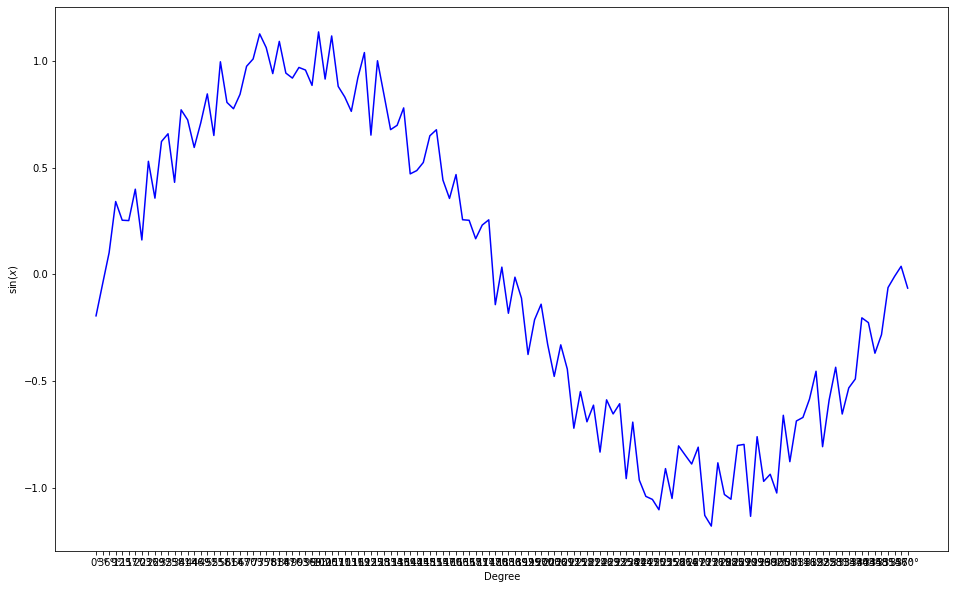

In [46]:
# Configuração do tamanho da figura
plt.figure(figsize=(16,10))

# Plotar uma linha específica do conjunto de dados de treino
plt.plot(columns_train_orig, dataset_train_orig.iloc[5], label="Seno", color='b')

# Configurações dos eixos
plt.xlabel("Degree")
plt.ylabel("$\sin(x)$")

# Exibir o gráfico
plt.show()

### Criação dos rotulos (_labels_) para conjuntos de dados de treino e validação, e conversão para tensores `PyTorch`
Este exemplo demonstra como criar labels para os conjuntos de dados de onda senoidal gerados, e como convertê-los para tensores `PyTorch` para uso em modelos de aprendizado profundo.

In [29]:
# Criar labels para os conjuntos de dados de treino e validação
y_train = np.array([np.zeros(dataset_train_orig.__len__())])
y_valid = np.array([np.zeros(dataset_valid_orig.__len__())])

# Converter os labels para tensores PyTorch e transpor
y_train_fold = torch.Tensor(y_train).T
y_valid_fold = torch.Tensor(y_valid).T

# Exibir os tamanhos dos tensores
y_train_fold.size(), y_valid_fold.size()


(torch.Size([200, 1]), torch.Size([20, 1]))

### Treinamento de uma Variational Autoencoder (VAE) em um conjunto de dados de onda senoidal

Este script define e treina um VAE usando dados de onda senoidal gerados artificialmente. 

Ele inclui:
- Preparação dos dados;
- Configuração do modelo;
- Execução do treinamento.

Configurações:
- Taxa de aprendizado, número de épocas, fator de redução do scheduler, perda mínima do scheduler, paciência do scheduler.
- Tipo de normalização, tamanho do batch, valores dos hiperparâmetros gamma.

In [30]:
# Configurações de treinamento
_lr = 1e-3  # Taxa de aprendizado
_epochs = 200  # Número de épocas de treinamento
_sched_factor = 0.1  # Fator de redução do scheduler
_sched_min_lr = 1e-6  # Perda mínima do scheduler
_sched_patience = 20  # Paciência do scheduler
_normalization = 'SNV'  # Tipo de normalização
_batch_size = 8  # Tamanho do batch
_gamma_1 = 1  # Hiperparâmetro gamma 1
_gamma_2 = 0.01  # Hiperparâmetro gamma 2
conv = True  # Flag para convolução

# Preparar conjuntos de dados
dataset_train = np.expand_dims(dataset_train_orig, 1)
dataset_valid = np.expand_dims(dataset_valid_orig, 1)

# Preparar DataLoaders
train_dataloader, train_size = prepare_data_loader(dataset_train, y_train_fold, batch_size=_batch_size, shuffle=True)
valid_dataloader, valid_size = prepare_data_loader(dataset_valid, y_valid_fold, batch_size=_batch_size, shuffle=False)

# Definir a rede VAE
VAE_network = VAE(layer_sizes=125, latent_dims=16).to(device)

# Parâmetros do otimizador
opt_parameters = list(VAE_network.parameters())

# Configuração do otimizador e scheduler
optimizer = optim.Adam(opt_parameters, weight_decay=1e-3, lr=_lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=_sched_factor, min_lr=_sched_min_lr, patience=_sched_patience, verbose=True)

# Critérios de perda
MSE_criterion = nn.MSELoss(reduction='sum')
MAE_criterion = nn.L1Loss(reduction='sum')

# Variáveis para armazenar perdas durante o treinamento
mean_train_loss = []
mean_valid_loss = []
curr_loss = 0
prev_loss = np.inf
limit_stop = 20  # Limite para early stopping

print('Training VAE')

# Loop de treinamento
for epoch in range(_epochs):
    running_loss = 0.0
    running_kld = 0.0
    running_recon = 0.0

    # Treinamento
    VAE_network.train()
    for train_data in train_dataloader:
        inputs, labels = train_data
        if conv:
            inputs = inputs.to(device)
        else:
            inputs = inputs.to(device).squeeze(1)

        labels = labels.type(dtype=torch.LongTensor).to(device)

        optimizer.zero_grad()

        # Passagem para frente
        inputs_pred, mean, logvar = VAE_network(inputs)

        # Calcular as perdas
        RECON_loss = MAE_criterion(inputs_pred, inputs)  # Reconstruction Loss
        KLD_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
        VAE_loss = (_gamma_1 * RECON_loss) + (_gamma_2 * KLD_loss)

        # Atualizar perdas acumuladas
        running_recon += _gamma_1 * RECON_loss.item() * inputs.size(0)
        running_kld += _gamma_2 * KLD_loss.item() * inputs.size(0)
        running_loss += VAE_loss.item() * inputs.size(0)

        # Backpropagation
        VAE_loss.backward()
        optimizer.step()

    # Cálculo das perdas por época
    epoch_kld = running_kld / train_size['y_size'][0]
    epoch_recon = running_recon / train_size['y_size'][0]
    epoch_loss = running_loss / train_size['y_size'][0]

    # Validação
    VAE_network.eval()
    valid_running_loss = 0.0
    valid_running_kld = 0.0
    valid_running_recon = 0.0

    with torch.no_grad():
        for valid_data in valid_dataloader:
            inputs, labels = valid_data
            if conv:
                inputs = inputs.to(device)
            else:
                inputs = inputs.to(device).squeeze(1)

            labels = labels.type(dtype=torch.LongTensor).to(device)

            # Passagem para frente
            x_pred, mean, logvar = VAE_network(inputs)

            # Calcular as perdas
            RECON_loss = MAE_criterion(x_pred, inputs)  # Reconstruction Loss
            KLD_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
            TVAE_loss = (_gamma_1 * RECON_loss) + (_gamma_2 * KLD_loss)

            # Atualizar perdas acumuladas
            valid_running_loss += TVAE_loss.item() * inputs.size(0)
            valid_running_recon += _gamma_1 * RECON_loss.item() * inputs.size(0)
            valid_running_kld += _gamma_2 * KLD_loss.item() * inputs.size(0)

        # Cálculo das perdas por época
        valid_epoch_loss = valid_running_loss / valid_size['y_size'][0]
        valid_epoch_kld = valid_running_kld / valid_size['y_size'][0]
        valid_epoch_recon = valid_running_recon / valid_size['y_size'][0]

        # Atualização do scheduler
        scheduler.step(valid_epoch_loss)
        curr_loss = valid_epoch_loss

    print(f'Epoch: {epoch} | Train Recon Loss: {epoch_recon:.4f} | Train KLD: {epoch_kld:.4f} | Train Loss: {epoch_loss:.4f}')
    print(f'Epoch: {epoch} | Valid Recon Loss: {valid_epoch_recon:.4f} | Valid KLD: {valid_epoch_kld:.4f} | Valid Loss: {valid_epoch_loss:.4f}')

    # Early Stopping
    if curr_loss > prev_loss and epoch > 50:
        print(f"prev_loss: {prev_loss:.4f}, curr_loss: {curr_loss:.4f}")
        trigger_times += 1
        print(f'Times without improvement: {trigger_times}')

        if trigger_times >= limit_stop:
            print(f'[*] Early stopping at Epoch: {epoch} !')
            break
    else:
        trigger_times = 0
        prev_loss = curr_loss

# Salvando o modelo
print('Saving VAE model!')
torch.save(VAE_network.state_dict(), f'./VAE_training_{_gamma_1}_{_gamma_2}.pth')

Training VAE
Epoch: 0 | Train Recon Loss: 191.7420 | Train KLD: 6.6066 | Train Loss: 198.3485
Epoch: 0 | Valid Recon Loss: 98.2124 | Valid KLD: 3.1523 | Valid Loss: 101.3647
Epoch: 1 | Train Recon Loss: 105.5457 | Train KLD: 3.4318 | Train Loss: 108.9774
Epoch: 1 | Valid Recon Loss: 97.4149 | Valid KLD: 2.4751 | Valid Loss: 99.8900
Epoch: 2 | Train Recon Loss: 104.1684 | Train KLD: 3.0881 | Train Loss: 107.2565
Epoch: 2 | Valid Recon Loss: 93.8990 | Valid KLD: 2.6656 | Valid Loss: 96.5646
Epoch: 3 | Train Recon Loss: 102.1138 | Train KLD: 2.3722 | Train Loss: 104.4859
Epoch: 3 | Valid Recon Loss: 93.9488 | Valid KLD: 2.1135 | Valid Loss: 96.0624
Epoch: 4 | Train Recon Loss: 101.8521 | Train KLD: 2.6968 | Train Loss: 104.5489
Epoch: 4 | Valid Recon Loss: 92.2285 | Valid KLD: 2.3663 | Valid Loss: 94.5948
Epoch: 5 | Train Recon Loss: 101.5600 | Train KLD: 3.2112 | Train Loss: 104.7712
Epoch: 5 | Valid Recon Loss: 93.7276 | Valid KLD: 3.4177 | Valid Loss: 97.1453
Epoch: 6 | Train Recon Los

### Processamento dos nomes das colunas do conjunto de dados de validação
Realiza um processamento para remover o símbolo de grau e convertê-los em inteiros. \
Este código converte os nomes das colunas de um DataFrame que representam graus (com símbolo °) em uma lista de inteiros, removendo o símbolo de grau.

In [31]:
# Extração dos nomes das colunas do conjunto de dados de validação
eixo_x = dataset_valid_orig.columns.values

# Remover o símbolo de grau ('°') dos nomes das colunas
array_without_degree_symbol = [string.replace('°', '') for string in eixo_x]

# Converter os nomes das colunas em inteiros
eixo_x = [int(number) for number in array_without_degree_symbol]


### Avaliação e plotagem da reconstrução de dados utilizando um VAE
Este código carrega um modelo VAE previamente treinado, realiza a reconstrução dos dados de validação, e plota a comparação entre os dados originais e reconstruídos.

VAE already exists. Loading model ./VAE_training_1_0.01.pth
Ploting VAE Reconstruction


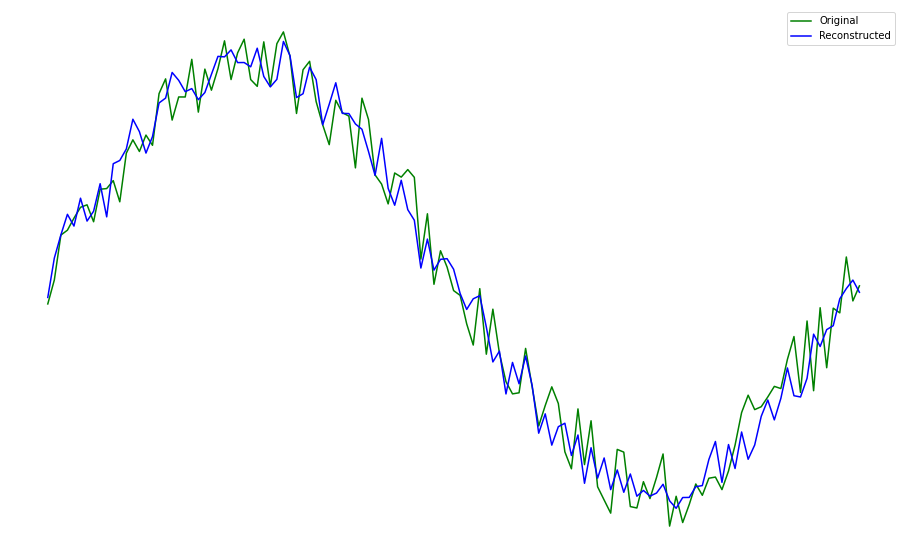

In [32]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Obter os nomes das colunas do conjunto de dados de validação
eixo_x = dataset_valid_orig.columns.values

# Definir a rede VAE e carregar o modelo treinado
VAE_network = VAE(layer_sizes=125, latent_dims=16).to(device)
vae_model_path = f'./VAE_training_{_gamma_1}_{_gamma_2}.pth'

if os.path.exists(vae_model_path):
    print(f'VAE already exists. Loading model {vae_model_path}')
    VAE_network.load_state_dict(torch.load(vae_model_path, map_location=device))
    VAE_network.eval()

# Inicializar tensores para armazenar os dados originais e reconstruídos
X_test_reconstructed = torch.Tensor()
X_test_original = torch.Tensor()

# Critério de perda MSE
MSE_criterion = nn.MSELoss(reduction='sum')

print('Ploting VAE Reconstruction')

# Avaliação do modelo VAE e armazenamento das reconstruções
with torch.no_grad():
    for test_data in valid_dataloader:
        inputs, labels = test_data
        if conv:
            inputs = inputs.to(device)
        else:
            inputs = inputs.to(device).squeeze(1)

        labels = labels.type(dtype=torch.LongTensor).to(device)
        
        # Variational AutoEncoder NN
        x_pred, mean, logvar = VAE_network(inputs)
        X_test_original = torch.cat((X_test_original, inputs.cpu()))
        X_test_reconstructed = torch.cat((X_test_reconstructed, x_pred.cpu()))

# Remover dimensões desnecessárias
X_test_reconstructed = X_test_reconstructed.squeeze(1)
X_test_original = X_test_original.squeeze(1)

# Plotar a comparação entre os dados originais e reconstruídos
plt.figure(figsize=(16,10))
plt.plot(eixo_x, X_test_original[-11], label="Original", color='g')
plt.plot(eixo_x, X_test_reconstructed[-11], label="Reconstructed", color='b')
plt.legend()
plt.axis('off')
plt.show()